# Histopathologic Cancer Detection

## Contents
1. Load data and EDA
2. Data Preprocessing
3. Build a first Model and evaluate
4. Hyperparameter tuning and find the best model
5. Conclusion

---
## 1. Load data and EDA

Before we training the model, we need to load the data and research the data.
How many images in the dataset? What is the size of the image? What is the label of the image?
and so on.

In [2]:
# importing libralies
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load train labels from CSV file
train_labels = pd.read_csv('train_labels.csv')

##### 1-A. What columns and how many rows are in the data?

In [4]:
print(train_labels.shape)

(220025, 2)


##### 1-B. What are the first 5 rows?

In [5]:
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


##### 1-C. How many distinct values are there in the label column and how many image does each has

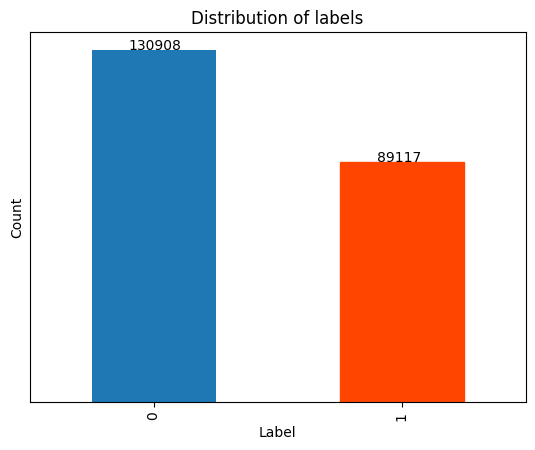

In [6]:
# Plot the distribution of the labels
train_labels['label'].value_counts().plot(kind='bar')
# set the title
plt.title('Distribution of labels')
# set the x-axis label
plt.xlabel('Label')
# set the y-axis label
plt.ylabel('Count')
# show the values on the bars
for i, v in enumerate(train_labels['label'].value_counts()):
    plt.text(i - 0.1, v + 10, str(v))
# delete the y-axis values
plt.gca().axes.yaxis.set_ticks([])
# change the x-axis bar color
plt.gca().get_children()[1].set_color('orangered')

##### 1-D. What images are in the dataset?
Let's show the 10 pictures with the labels randomly.
Load train images from 'train' folder.

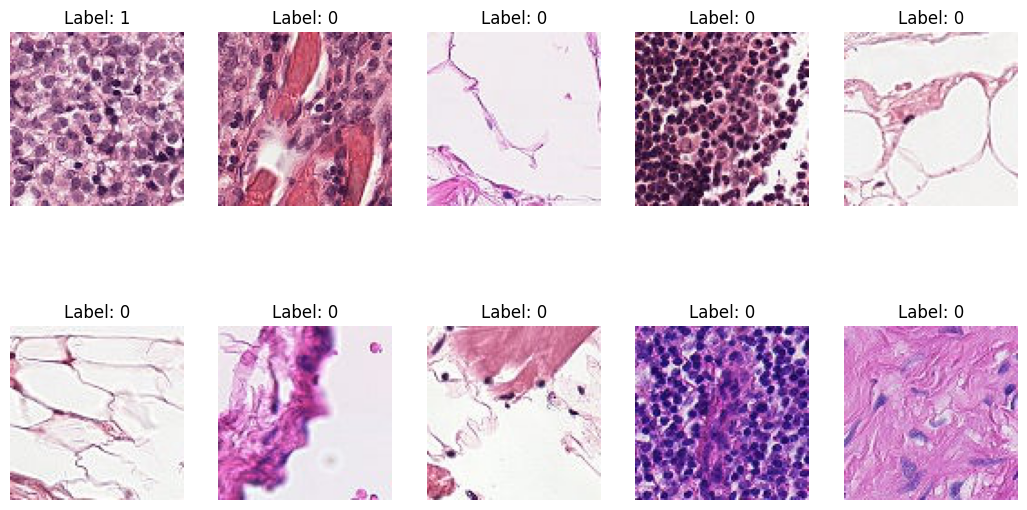

In [7]:
# Get the list of all images
images_list = os.listdir('train')

# Choose 10 random numbers between 0 and the number of images_list
random_indices = np.random.choice(len(images_list), 10, replace=False)

# Display 10 images with their labels
fig = plt.figure(figsize=(13, 7))
for j, i in enumerate(random_indices):
    plt.subplot(2, 5, j + 1)
    # Read and display an image with the specified index
    img = plt.imread('train/' + images_list[i])
    plt.imshow(img)
    # Get the label of the image
    label = train_labels[train_labels['id'] == images_list[i].split('.')[0]]['label'].values[0]
    plt.title('Label: ' + str(label))
    plt.axis('off')

##### 1-E. what shape does the image have?

In [8]:
print(img.shape)

(96, 96, 3)


96 x 96 x 3 (height x width x color channels)

---
## 2. Data Preprocessing
For the data preprocessing, we will:
- Normalize the size of the images
- Splitting the data into training and validation sets
- Transform the images into tensors

In [9]:
# Define the batch size and target size
batch_size = 64
target_size = (60, 60)

# Create an ImageDataGenerator for rescaling the images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Update 'id' column to match file names and convert 'label' to string for generator
train_dir = r"C:\cousera\deep3\train"  
train_labels['id'] = train_labels['id'].astype(str)
train_labels['label'] = train_labels['label'].astype(str)

# 'id' extension is 'tif', so we need to add it to match the file names
train_labels['id'] = train_labels['id'] + '.tif'

# Create a generator for training images
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

# Create a generator for validation images
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


---
## 3. Build a first Model and evaluate
Now that we have the data generators, we build the first model using the deep learning framework TensorFlow. 
We will make two models, one model without convolutional layers and one model with convolutional layers.


##### 3A. Define the callback function of saving the best model and plot the model history

In [10]:
# Define the model checkpoint
def make_checkpoint(model_name):

    now = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())

    return ModelCheckpoint(filepath=f'best_{model_name}_{now}.h5',  # model filename
                           monitor='val_accuracy',  # quantity to monitor
                           mode='max',  # mode - maximize the quantity
                           save_best_only=True,  # save the best model
                           verbose=1)  # verbosity mode - 1: update messages


# Define the function of ploting the training history
def plot_history(history):

    # rigth history for accuracy of train and validation
    # left history for loss of train and validation

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # summarize history for accuracy
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    # change y-axis 0 to 1
    ax[0].set_ylim(0, 1)
    # set x-axis 0 to max epoch
    ax[0].set_xlim(0, len(history.history['accuracy']))
    # set x-axis ticks to integers
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(len(history.history['accuracy']) + 1))

    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')
    # change y-axis 0 to max value*1.1
    ax[1].set_ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1)
    # set x-axis 0 to max epoch
    ax[1].set_xlim(0, len(history.history['accuracy']))
    # set x-axis ticks to integers
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(len(history.history['accuracy']) + 1))

    # print the max validation accuracy and min validation loss and their epochs
    print(f"Max validation accuracy: {max(history.history['val_accuracy'])} at epoch {np.argmax(history.history['val_accuracy']) + 1}")
    print(f"Min validation loss: {min(history.history['val_loss'])} at epoch {np.argmin(history.history['val_loss']) + 1}")

    plt.show();

##### 3B. Build a model without convolutional layers(only dense and flatten layers)

In [63]:
# Without convolutional layers(only dense and flatten layers)
model = Sequential([
    Input(shape=(60, 60, 3)),  # Define the input shape here
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')  # 2 units for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 10800)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               5530112   
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 5531138 (21.10 MB)
Trainable params: 5531138 (21.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# make a checkpoint
check_point = make_checkpoint('NoCNN')

# Fit the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[check_point])

Epoch 1/5
2751/2751 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.6057
Epoch 1: val_accuracy improved from -inf to 0.62922, saving model to best_NoCNN_2024-09-11-06-42-06.h5
2751/2751 [==============================] - 698s 254ms/step - loss: 0.6726 - accuracy: 0.6057 - val_loss: 0.6179 - val_accuracy: 0.6292


c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/5
2751/2751 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.6525
Epoch 2: val_accuracy improved from 0.62922 to 0.69928, saving model to best_NoCNN_2024-09-11-06-42-06.h5
2751/2751 [==============================] - 696s 253ms/step - loss: 0.6149 - accuracy: 0.6525 - val_loss: 0.6026 - val_accuracy: 0.6993
Epoch 3/5
2751/2751 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.6741
Epoch 3: val_accuracy improved from 0.69928 to 0.70394, saving model to best_NoCNN_2024-09-11-06-42-06.h5
2751/2751 [==============================] - 684s 249ms/step - loss: 0.6048 - accuracy: 0.6741 - val_loss: 0.6000 - val_accuracy: 0.7039
Epoch 4/5
2751/2751 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.6935
Epoch 4: val_accuracy improved from 0.70394 to 0.70585, saving model to best_NoCNN_2024-09-11-06-42-06.h5
2751/2751 [==============================] - 679s 247ms/step - loss: 0.5911 - accuracy: 0.6935 - val_loss: 0.5814 - v

Max validation accuracy: 0.7058516144752502 at epoch 4
Min validation loss: 0.58144611120224 at epoch 4


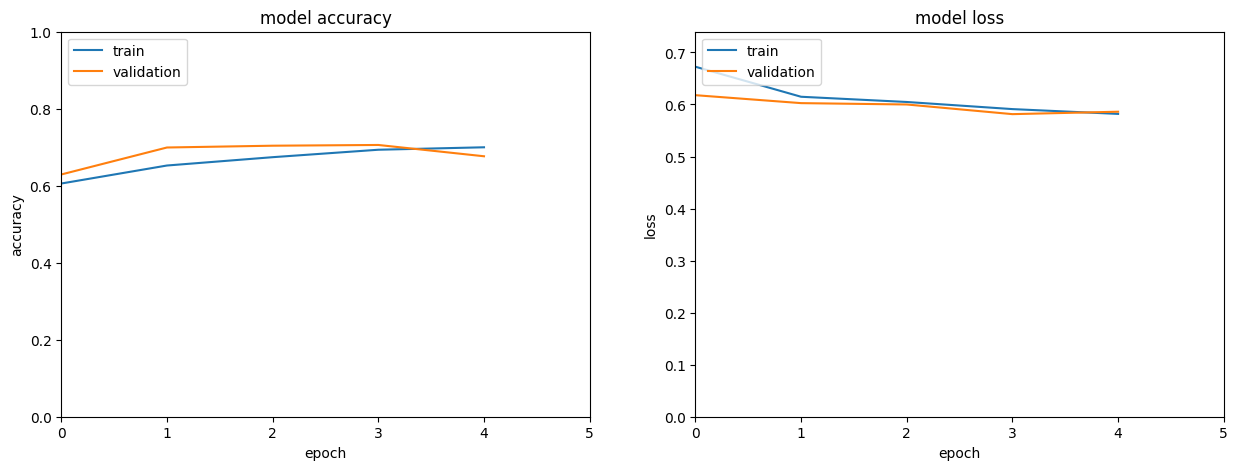

In [65]:
# Plot the training history
plot_history(history)

##### 3C. Build a model with convolutional layers(CNN model)

In [66]:
# Define the CNN architecture using Input object
model = Sequential([
    Input(shape=(60, 60, 3)),  # Define the input shape here
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 units for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)         

In [67]:
# make a checkpoint
check_point = make_checkpoint('CNN_3Conv')

# Fit the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[check_point])

Epoch 1/5
2751/2751 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8032
Epoch 1: val_accuracy improved from -inf to 0.84022, saving model to best_CNN_3Conv_2024-09-11-07-39-20.h5
2751/2751 [==============================] - 833s 303ms/step - loss: 0.4343 - accuracy: 0.8032 - val_loss: 0.3692 - val_accuracy: 0.8402
Epoch 2/5
2751/2751 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8409
Epoch 2: val_accuracy improved from 0.84022 to 0.84949, saving model to best_CNN_3Conv_2024-09-11-07-39-20.h5
2751/2751 [==============================] - 830s 302ms/step - loss: 0.3634 - accuracy: 0.8409 - val_loss: 0.3481 - val_accuracy: 0.8495
Epoch 3/5
2751/2751 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8522
Epoch 3: val_accuracy did not improve from 0.84949
2751/2751 [==============================] - 831s 302ms/step - loss: 0.3429 - accuracy: 0.8522 - val_loss: 0.3805 - val_accuracy: 0.8280
Epoch 4/5
2751/2751 [=========

Max validation accuracy: 0.8700829744338989 at epoch 5
Min validation loss: 0.30841121077537537 at epoch 5


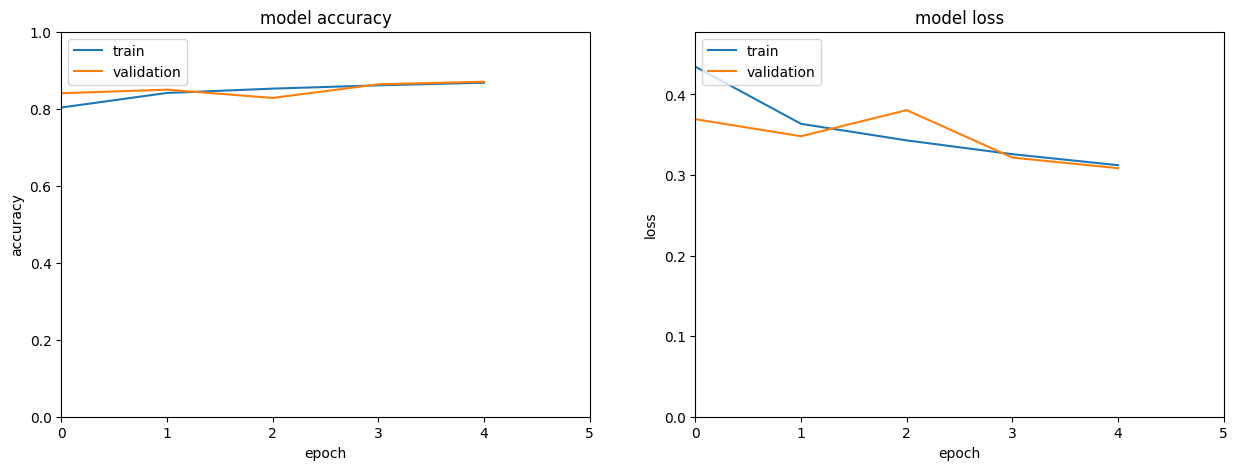

In [68]:
# Plot the training history
plot_history(history)

---
## 4.Hyperparameter tuning and find the best model
The validation accuracy of the model which has 3 convolutional layers is approximately 0.8 and without convolutional layers is approximately 0.7.

This is not good enough for the model to be used in practice.So, we need to tune the hyperparameters to improve the model's performance.

In this section, we will tune the hyperparameters of the model which has 3 convolutional layers.

- Reduce the learning rate of the Adam optimizer to 0.0001.

- Add BatchNormalization layers after each Conv2D layer.

- Add L2 regularization to the Conv2D layers with a regularization parameter of 0.01.

- Transfer learning with ResNet50


##### 4A. Reduce the learning rate of the Adam optimizer to 0.0001.

In [69]:
# change the lerning rate

# Define the CNN architecture using Input object
model = Sequential([
    Input(shape=(60, 60, 3)),  # Define the input shape here
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 units for binary classification
])

# Compile the model with a variable learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)         

In [70]:
# make a checkpoint
check_point = make_checkpoint('CNN_Adj_LearningRate')

# Train the model 
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[check_point])

Epoch 1/5
2751/2751 [==============================] - ETA: 0s - loss: 0.4812 - accuracy: 0.7767
Epoch 1: val_accuracy improved from -inf to 0.79371, saving model to best_CNN_Adj_LearningRate_2024-09-11-08-48-26.h5
2751/2751 [==============================] - 816s 296ms/step - loss: 0.4812 - accuracy: 0.7767 - val_loss: 0.4497 - val_accuracy: 0.7937
Epoch 2/5
2751/2751 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8003
Epoch 2: val_accuracy improved from 0.79371 to 0.81463, saving model to best_CNN_Adj_LearningRate_2024-09-11-08-48-26.h5
2751/2751 [==============================] - 823s 299ms/step - loss: 0.4399 - accuracy: 0.8003 - val_loss: 0.4129 - val_accuracy: 0.8146
Epoch 3/5
2751/2751 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8178
Epoch 3: val_accuracy improved from 0.81463 to 0.82538, saving model to best_CNN_Adj_LearningRate_2024-09-11-08-48-26.h5
2751/2751 [==============================] - 814s 296ms/step - loss: 0.4069

Max validation accuracy: 0.8436768651008606 at epoch 5
Min validation loss: 0.3570527136325836 at epoch 5


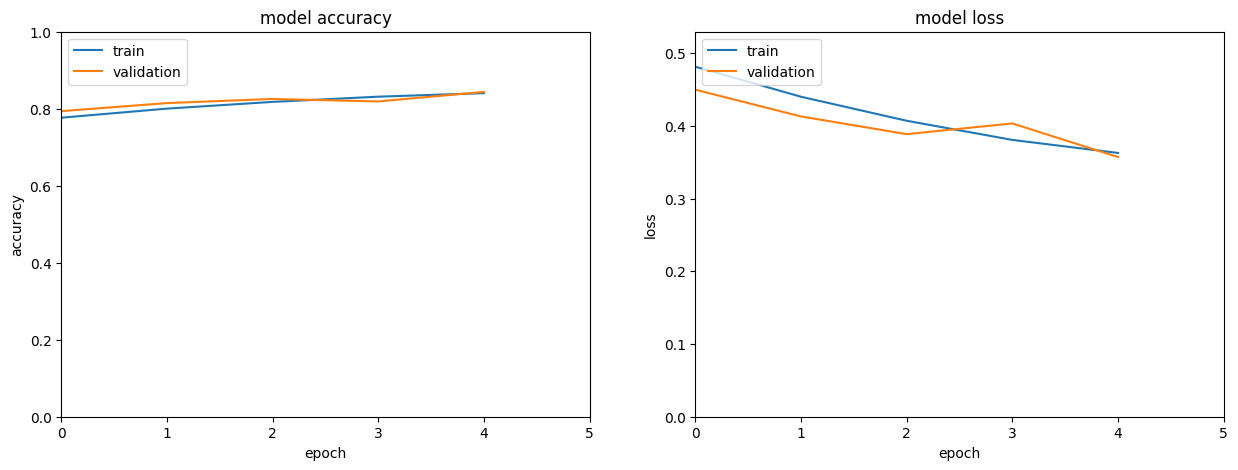

In [71]:
# Plot the training history
plot_history(history)

##### 4B. Add BatchNormalization layers after each Conv2D layer.

In [72]:
# Define the CNN architecture using Input object
model = Sequential([
    Input(shape=(60, 60, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 58, 58, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 58, 58, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 32)        128       
 chNormalization)                                                
                                                      

In [73]:
# make a checkpoint
check_point = make_checkpoint('CNN_BatchNorm')

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[check_point])

Epoch 1/5
2751/2751 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8362
Epoch 1: val_accuracy improved from -inf to 0.82488, saving model to best_CNN_BatchNorm_2024-09-11-09-56-21.h5
2751/2751 [==============================] - 834s 303ms/step - loss: 0.3866 - accuracy: 0.8362 - val_loss: 0.4390 - val_accuracy: 0.8249
Epoch 2/5
2751/2751 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8653
Epoch 2: val_accuracy improved from 0.82488 to 0.84479, saving model to best_CNN_BatchNorm_2024-09-11-09-56-21.h5
2751/2751 [==============================] - 833s 303ms/step - loss: 0.3209 - accuracy: 0.8653 - val_loss: 0.3716 - val_accuracy: 0.8448
Epoch 3/5
2751/2751 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.8810
Epoch 3: val_accuracy did not improve from 0.84479
2751/2751 [==============================] - 830s 302ms/step - loss: 0.2871 - accuracy: 0.8810 - val_loss: 0.6597 - val_accuracy: 0.7444
Epoch 4/5
2751/2751 [=

Max validation accuracy: 0.8724235892295837 at epoch 5
Min validation loss: 0.3716357350349426 at epoch 2


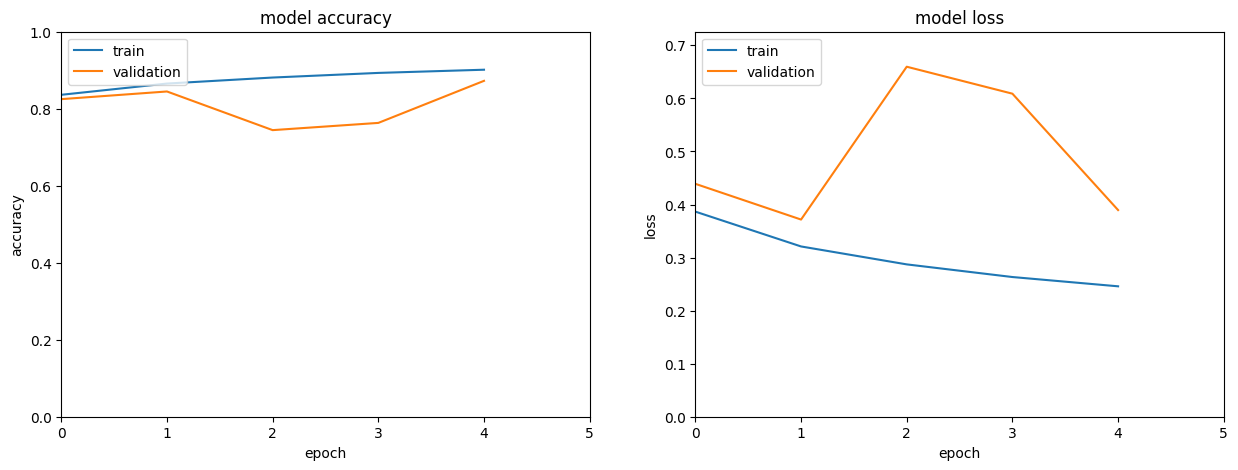

In [74]:
# Plot the training history
plot_history(history)

##### 4C. Add L2 regularization to the Conv2D layers with a regularization parameter of 0.01.


In [75]:
# Define the CNN architecture using Input object
model = Sequential([
    Input(shape=(60, 60, 3)),
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 64)         

In [76]:
# make a checkpoint
check_point = make_checkpoint('CNN_L2')

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[check_point])

Epoch 1/5
2751/2751 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.7743
Epoch 1: val_accuracy improved from -inf to 0.79714, saving model to best_CNN_L2_2024-09-11-11-05-33.h5
2751/2751 [==============================] - 792s 288ms/step - loss: 0.6008 - accuracy: 0.7743 - val_loss: 0.4995 - val_accuracy: 0.7971
Epoch 2/5
2751/2751 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.8036
Epoch 2: val_accuracy improved from 0.79714 to 0.82638, saving model to best_CNN_L2_2024-09-11-11-05-33.h5
2751/2751 [==============================] - 795s 289ms/step - loss: 0.4842 - accuracy: 0.8036 - val_loss: 0.4464 - val_accuracy: 0.8264
Epoch 3/5
2751/2751 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.8179
Epoch 3: val_accuracy did not improve from 0.82638
2751/2751 [==============================] - 796s 289ms/step - loss: 0.4554 - accuracy: 0.8179 - val_loss: 0.4456 - val_accuracy: 0.8195
Epoch 4/5
2751/2751 [===============

Max validation accuracy: 0.8263833522796631 at epoch 2
Min validation loss: 0.4415586590766907 at epoch 4


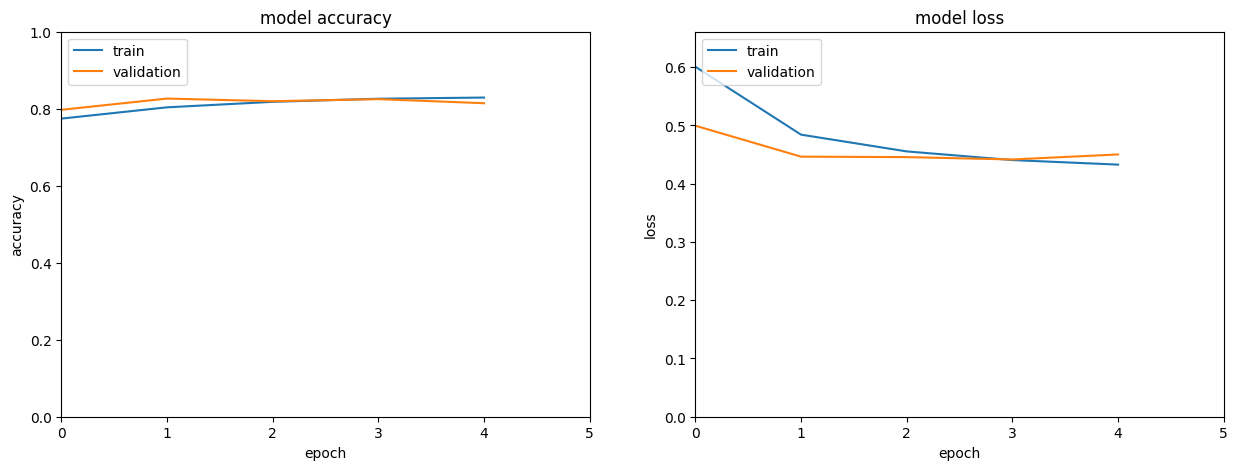

In [77]:
# Plot the training history
plot_history(history)

##### 4D. Transfer learning with ResNet50

In [11]:
# Base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(60, 60, 3))

# Freeze the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27783554 (105.99 MB)
Trainable params: 27730434 (105.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [12]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
# make a checkpoint
check_point = make_checkpoint('ResNet50_early_stopping')

In [13]:
# Base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(60, 60, 3))

# Freeze the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 27783554 (105.99 MB)
Trainable params: 27730434 (105.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [14]:
# train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[check_point, early_stopping])

Epoch 1/5
2751/2751 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.8962
Epoch 1: val_accuracy improved from -inf to 0.92192, saving model to best_ResNet50_early_stopping_2024-09-12-00-38-39.h5


c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2751/2751 [==============================] - 5695s 2s/step - loss: 0.2630 - accuracy: 0.8962 - val_loss: 0.2022 - val_accuracy: 0.9219
Epoch 2/5
2751/2751 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9371
Epoch 2: val_accuracy did not improve from 0.92192
2751/2751 [==============================] - 5626s 2s/step - loss: 0.1657 - accuracy: 0.9371 - val_loss: 0.3269 - val_accuracy: 0.8751
Epoch 3/5
2751/2751 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9550
Epoch 3: val_accuracy improved from 0.92192 to 0.93733, saving model to best_ResNet50_early_stopping_2024-09-12-00-38-39.h5
2751/2751 [==============================] - 5591s 2s/step - loss: 0.1204 - accuracy: 0.9550 - val_loss: 0.1793 - val_accuracy: 0.9373
Epoch 4/5
2751/2751 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9677
Epoch 4: val_accuracy did not improve from 0.93733
2751/2751 [==============================] - 5980s 2s/step - loss: 0.0872 - ac

Max validation accuracy: 0.9381661415100098 at epoch 5
Min validation loss: 0.1793433278799057 at epoch 3


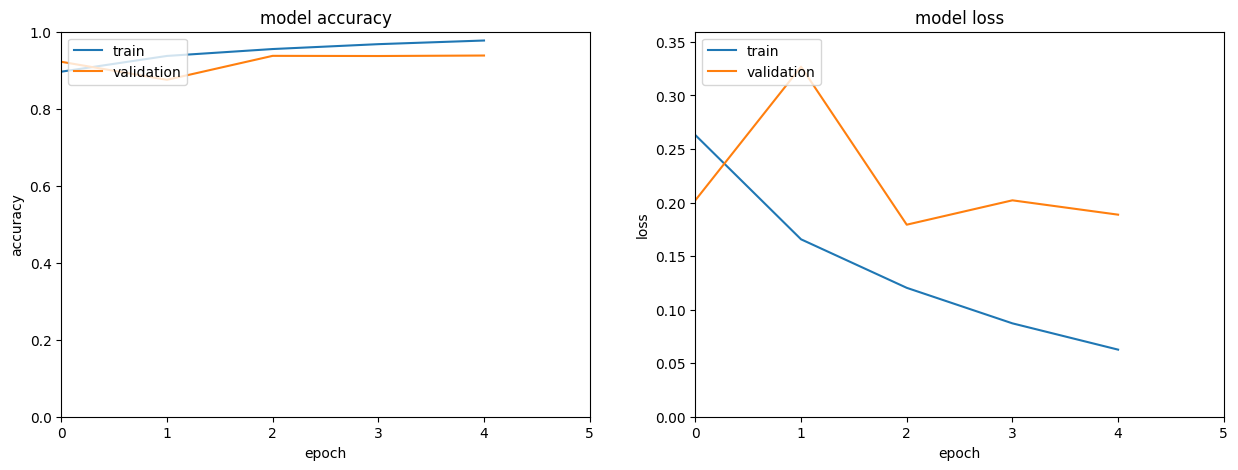

In [15]:
# Plot the training history
plot_history(history)

##### 4E. Summary of each model's performance and build a best model using the early stopping callback

The accuracy of the models is as follows:
|Method|Validation accuracy|
|:----|:--------:|
|CNN base| 0.87 |
|Reduce learning rate| 0.84 |
|BatchNormalization| 0.87 |
|L2 regularization| 0.82 |
|ResNet50| 0.94 |

The best model is the transfer learning model using ResNet50.
To build this model takes too long time so I add the early stopping callback to the model.



**The reasons for the ResNet50 model to be the best are:**

The medical images are complex and contain a lot of features that are difficult to extract using a simple CNN model.
ResNet50 is a deep neural network with 50 layers that can learn complex features from the images.
The model has already been trained on the ImageNet dataset, which contains a large number of images from different categories.
The model can be fine-tuned to work well on the medical images dataset.

---
## 5. Conclusion

In this project, we have built a deep learning model to classify images of histopathologic cancer. 
We have used a convolutional neural network (CNN) with different architectures and techniques to improve the model's performance.
We have also used a pre-trained model (ResNet50) to classify the images and compared its performance with the CNN model.

The best model we have built is the ResNet50 model.

In this project, changing the learning rate, adding batch normalization, and using L2 regularization did not improve the model's performance.

To build a better model, I think it would be helpful to use external pretrained models like ResNet50, and tune the hyperparameters of the model to improve its performance.


**So, let's predict the test images using the best model we have built (ResNet50) and submit the results to Kaggle.**

In [16]:
test_dir = r"C:\cousera\deep3\test"  # Replace 'train' with the correct directory path

# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [17]:
# 'ResNet50.h5' is the model filename
model = load_model('best_ResNet50_early_stopping_2024-09-12-00-38-39.h5')

# Make predictions
predictions = model.predict(test_generator)

# Get the predicted classes and save as 'train_labels.csv' file name without the extension as the 'id' column and 'label' column
predicted_classes = np.argmax(predictions, axis=1)
# Get the filenames from the generator
filenames = test_generator.filenames

57458/57458 [==============================] - 1827s 32ms/step


In [18]:
# Remove the extension from the filenames
filename_withot = [filename.replace('.tif', '') for filename in filenames]
filename_withot
# Create a DataFrame with filenames and predicted classes
results = pd.DataFrame({'id': filename_withot, 'label': predicted_classes})
# Save the results to a CSV file
results.to_csv('sample_submission.csv', index=False)

# Load the test labels from the CSV file and display the first 5 rows
test_labels = pd.read_csv('sample_submission.csv')
print(test_labels.head())
print(test_labels.shape)

                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      1
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      1
4  000270442cc15af719583a8172c87cd2bd9c7746      0
(57458, 2)
